## Modules <a name="modules"></a>

First we need to install SHAP for displaying feature importance later.

In [1]:
# Install all necessary modules not native to Colab
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then we import all our modules.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import shap
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset and Tokenization

We will first load our dataset into a pandas dataframe, dropping several columns that will not be impactful as features.

We also remove all examples where either the rating is null or the number of ratings is 0.

In [3]:
# Load all the data
dataset = pd.read_csv("/content/drive/MyDrive/PlayStore/Google-Playstore.csv", delimiter=',')
dataset = dataset.drop(columns=['App Id', 'Privacy Policy', 'Scraped Time', 'Developer Website', 'Developer Email', 'Installs', 'Minimum Installs'])
dataset = dataset[pd.isnull(dataset['Rating'])==False]
dataset = dataset[dataset['Rating Count'] != 0]
dataset = dataset.reset_index(drop=True)
original = dataset.copy(deep=True)
dataset

,App Name,Category,Rating,Rating Count,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice
0,Ampere Battery Info,Tools,4.4,64.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,"May 21, 2020","May 06, 2021",Everyone,True,False,False
1,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False,False
2,unlimited 4G data prank free app,Libraries & Demo,4.5,12.0,2567,True,0.0,USD,2.5M,4.1 and up,android developer779,"Sep 23, 2019","Sep 27, 2019",Everyone,True,False,False
3,The Everyday Calendar,Lifestyle,2.0,39.0,702,True,0.0,USD,16M,5.0 and up,Mozaix LLC,"Jun 21, 2019","Jun 21, 2019",Everyone,False,False,False
4,Neon 3d Iron Tech Keyboard Theme,Personalization,4.7,820.0,62433,True,0.0,USD,3.5M,4.1 and up,Free 2021 Themes for Emoji keyboard,"Sep 22, 2019","Oct 07, 2020",Everyone,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230294,Caustic Editor for VolcaSample,Music & Audio,4.0,344.0,814548,True,0.0,USD,4.1M,2.2 and up,Single Cell Software,"Dec 11, 2014","Dec 11, 2014",Everyone,False,False,False
1230295,Lero TOEFL Recorder + Timer,Education,3.4,17.0,1980,True,0.0,USD,10M,4.1 and up,Julio Augusto Vera,"May 22, 2018","Dec 14, 2018",Everyone,True,False,False
1230296,大俠客—熱血歸來,Role Playing,4.3,16775.0,337109,True,0.0,USD,77M,4.1 and up,ALICE GAME,NaN,"Jun 01, 2021",Teen,False,False,False
1230297,Devi Suktam,Music & Audio,3.5,8.0,2635,True,0.0,USD,10M,5.0 and up,Bhakti,"Aug 1, 2016","May 05, 2021",Everyone,True,False,False


In [5]:
# Run to restore dataset.
dataset = original.copy(deep=True)

We then define a function for tokenizing textual data by unique labels.

In [4]:
# Function for tokenizing unique values of textual data.
def tokenize_text(values):
  # Zip together a dict map with labels as indices and their position in 'labels' as their value.
  labels = values.unique()
  token_map = dict(zip(labels, [x for x in range(len(labels))]))
  return token_map

Using this function, we then tokenize all textual and boolean columns. 

In [5]:
# Hold all mappings for future reference.
token_maps = []

# Uniquely handle certain columns.
tokenize_cols = ['Category', 'Currency', 'Content Rating', 'Minimum Android', 'Developer Id']
for column in tokenize_cols:
  token_maps.append(tokenize_text(dataset[column]))
  dataset[column] = dataset[column].map(token_maps[-1])
  #print(f"{column}:\n{token_maps[-1]}")

# Uniformly handle boolean columns.
tokenize_bools = ['Free', 'Ad Supported', 'In App Purchases', 'Editors Choice']
token_maps.append({True: 1, False: 0})
for column in tokenize_bools:
  dataset[column] = dataset[column].map(token_maps[-1])
  #print(f"{column}:\n{token_maps[-1]}")

We then tokenize the app names by using their length, since doing word recognition would be too complex for our time limit.

In [6]:
# Replace names with their length.
dataset['App Name'] = dataset['App Name'].map(lambda s: len(str(s)))

We need to separately tokenize the dates by first updating them to reflect the number of days since the play store's launch.

In [7]:
# Sets all the dates to the Timestamp pandas datatype 
dataset['Released'] = pd.to_datetime(dataset['Released'], format='%b %d, %Y')
dataset['Last Updated'] = pd.to_datetime(dataset['Last Updated'], format='%b %d, %Y')
# Variable for the day the Google play store was launched
play_release = pd.to_datetime('Mar 6, 2012', format='%b %d, %Y')

# Sets all of the Released column in the dataset to days since Google play store launched
release_dates = []
for i, date in enumerate(dataset['Released']):
  if pd.isnull(date):
    # dataset['Released'].at[i] = (dataset['Last Updated'][i] - play_release).days
    release_dates.append((dataset['Last Updated'][i] - play_release).days)
  else: 
    # dataset['Released'].at[i] = (date - play_release).days
    release_dates.append((date - play_release).days)
dataset['Released'] = release_dates

# Sets all of the Last Updated column to days since Google play store was launched
update_dates = []
for i, date in enumerate(dataset['Last Updated']):
  update_dates.append((date - play_release).days)
dataset['Last Updated'] = update_dates

Then we tokenize size, the final feature, by simply converting all the values to megabytes and setting all missing values to the average.

In [8]:
# Converts all sizes to megabytes, all varies to average size, and all nan to average size
sizes = []
zero_count = 0
for i, size in enumerate(dataset['Size']):
  if(type(size) == float):
    zero_count += 1
    sizes.append(0)
    continue
  if('M' in size):
    if (',' in size):
      size = size.replace(',', '')
    sizes.append(float(size[:len(size)-1]))
  elif('k' in size):
    if (',' in size):
      size = size.replace(',', '')
    sizes.append(round(float(size[:len(size)-1])/1000, 2))
  elif('Varies' in size):
    zero_count += 1
    sizes.append(0)
  else:
    sizes.append(round(float(size[:len(size)-1]) * 1000, 2))
sizes_average = round(sum(sizes)/(len(sizes) - zero_count), 2)
for index, size in enumerate(sizes):
    if size == 0:
        sizes[index] = sizes_average
dataset['Size'] = sizes

Finally we normalize each feature using their minimum and maximum values.

In [9]:
# Normalizes the values of each column between their min and max value.
dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())

In [10]:
dataset

,App Name,Category,Rating,Rating Count,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice
0,0.367347,0.000000,0.850,4.258158e-07,6.354484e-07,1.0,0.0,0.0,0.001927,0.000000,0.000000,0.913265,0.990909,0.0,1.0,0.0,0.0
1,1.000000,0.021277,1.000,0.000000e+00,1.575766e-09,1.0,0.0,0.0,0.001193,0.007407,0.000002,0.775954,0.783370,0.0,1.0,0.0,0.0
2,0.632653,0.042553,0.875,5.052052e-08,2.128943e-07,1.0,0.0,0.0,0.001660,0.014815,0.000004,0.859805,0.860754,0.0,1.0,0.0,0.0
3,0.408163,0.063830,0.250,2.453854e-07,5.822041e-08,1.0,0.0,0.0,0.010660,0.000000,0.000006,0.838953,0.839024,0.0,0.0,0.0,0.0
4,0.632653,0.085106,0.925,5.882032e-06,5.177884e-06,1.0,0.0,0.0,0.002327,0.014815,0.000008,0.859583,0.944124,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230294,0.591837,0.404255,0.750,2.446637e-06,6.755459e-05,1.0,0.0,0.0,0.002727,0.103704,0.051392,0.472272,0.472506,0.0,0.0,0.0,0.0
1230295,0.530612,0.489362,0.600,8.660660e-08,1.642114e-07,1.0,0.0,0.0,0.006660,0.014815,0.999998,0.751331,0.797118,0.0,1.0,0.0,0.0
1230296,0.142857,0.914894,0.825,1.210327e-04,2.795815e-05,1.0,0.0,0.0,0.051327,0.014815,0.124028,0.996673,0.996674,0.2,0.0,0.0,0.0
1230297,0.204082,0.404255,0.625,2.165165e-08,2.185339e-07,1.0,0.0,0.0,0.006660,0.000000,0.002902,0.605146,0.990687,0.0,1.0,0.0,0.0


## Data Split and Training Function

We then split our training and test data using a 70:30 split before reshaping them to make them numpy arrays.

In [11]:
# Split the data into training and testing sets.
train_data, test_data = train_test_split(dataset, train_size=0.7, test_size=0.3)
train_data, test_data = train_data.sort_index(), test_data.sort_index()
train_data_x, test_data_x = train_data.drop(columns=['Rating']), test_data.drop(columns=['Rating'])
train_data_y, test_data_y = train_data['Rating'], test_data['Rating']

train_data_x = np.reshape(train_data_x.values, (train_data_x.shape[0], -1))
train_data_y = np.reshape(train_data_y.values, -1)
test_data_x = np.reshape(test_data_x.values, (test_data_x.shape[0], -1))
test_data_y = np.reshape(test_data_y.values, -1)

In [12]:
# Save the first 50 entries of the test data for later subset evaluation.
test_data.head(50).to_csv("/content/drive/MyDrive/PlayStore/Test-Data.csv")

We then define a generic training function to use with different configurations of hyperparameters.

In [13]:
def Train_Model(batch_size, epochs, model, optimizer, metric, train_x=train_data_x, train_y=train_data_y, test_x=test_data_x, test_y=test_data_y, verbose=0):
  # Train the model.
  model.compile(loss=metric, optimizer=optimizer, metrics=[metric])
  history = model.fit(train_x, train_y, batch_size=batch_size, 
                    epochs=epochs, validation_data=(test_x, test_y),
                    verbose=verbose,)
  test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=0)
  # Return the accuracy.
  return history, test_loss, test_acc

With these now setup, we can move forward with testing various models and parameters.

## Testing Models & Features

To start, we need to construct a model to use and derive from for making changes. 

To quicken the computation of these models, we will use the following paramters as placeholders for later.

In [106]:
# Training settings.
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
metric = 'mse'
batch_size = 512
epochs = 10

### Layers & Neurons

We will experiment with three styles of feed forward networks, one with an increasing number of neurons, one with a decreasing number of neurons, and an hourglass-shaped configuration of neurons.

#### Increasing

This and future models in this section will use relu activations for hidden layers and a sigmoid activation for the output layer since it makes sense for the dataset and problem.

The increasing model will start with 32 neurons and increase by that much for each further layer.

In [29]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(96, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                544       
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 96)                6240      
                                                                 
 dense_23 (Dense)            (None, 128)               12416     
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1683/1683 [============================

After training, we see that this configuration converges with a consistent MSE of ~0.0279 after 10 epochs.

(Increasing):	MSE=0.027838392183184624


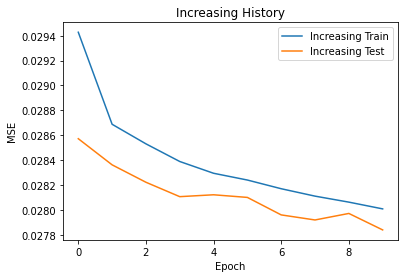

In [30]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Increasing Train')
plt.plot(history.history['val_mse'], label = 'Increasing Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Increasing History")
print(f"(Increasing):\tMSE={test_acc}")

By graphing the results, we see the improvement in MSE begin to flatten out at around 10 epochs.

#### Decreasing

The decreasing model will have the same configuration as the increasing model, but with the number of neurons in the hidden layers inverted, starting at 128 and decreasing each time by 32.

In [32]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(96, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               2176      
                                                                 
 dense_26 (Dense)            (None, 96)                12384     
                                                                 
 dense_27 (Dense)            (None, 64)                6208      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,881
Trainable params: 22,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1683/1683 [============================

Compared to the increasing model, we see that this one is extremely comparable in terms of both time taken to converge and in the resulting loss. Its final MSE is around 0.0279 for the test set.

(Decreasing):	MSE=0.027872025966644287


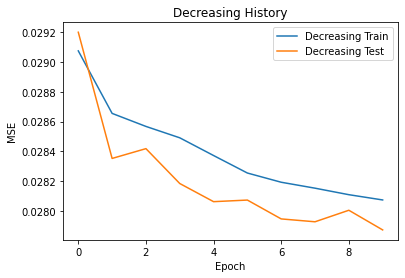

In [33]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Decreasing Train')
plt.plot(history.history['val_mse'], label = 'Decreasing Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Decreasing History")
print(f"(Decreasing):\tMSE={test_acc}")

However, when looking at the graph, we see that the test error is comparably more unstable in its convergence.

#### Hour-Glass

The hour-glass model will go from 48 neurons in the first layer, to 108 neurons in the middle layer, to 48 neurons in the last hidden layer.

In [41]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 48)                816       
                                                                 
 dense_49 (Dense)            (None, 76)                3724      
                                                                 
 dense_50 (Dense)            (None, 108)               8316      
                                                                 
 dense_51 (Dense)            (None, 76)                8284      
                                                                 
 dense_52 (Dense)            (None, 48)                3696      
                                                                 
 dense_53 (Dense)            (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-trai

As perhaps was expected, we again converge at around 0.0279 for our testing error after 10 epochs using this model.

(Hour-Glass):	MSE=0.02779451198875904


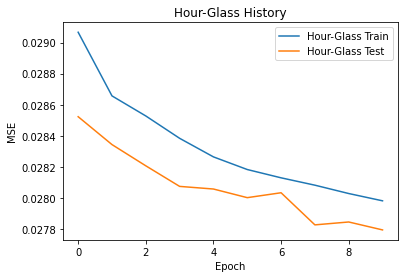

In [42]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Hour-Glass Train')
plt.plot(history.history['val_mse'], label = 'Hour-Glass Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Hour-Glass History")
print(f"(Hour-Glass):\tMSE={test_acc}")

Looking at the graph, we see a similar stability to the increasing configuration. Additionally, this model's initial error in the first epoch is lower than that of the increasing model.

Because of the lack of difference in final convergence and the only significant difference being in stability and initial error, we will use the hour-glass model in our final configuration.

### Activation Functions

The only two reasonable activation functions to use for our hidden layers is ReLu or TanH. Sigmoid is the obvious choice for our output layer since our predictions can only range between 0 and 1. 

#### TanH Exclusively

Replacing all instances of ReLu with TanH give us the below model.

In [43]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='tanh', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='tanh'))
model.add(keras.layers.Dense(108, activation='tanh'))
model.add(keras.layers.Dense(76, activation='tanh'))
model.add(keras.layers.Dense(48, activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 48)                816       
                                                                 
 dense_55 (Dense)            (None, 76)                3724      
                                                                 
 dense_56 (Dense)            (None, 108)               8316      
                                                                 
 dense_57 (Dense)            (None, 76)                8284      
                                                                 
 dense_58 (Dense)            (None, 48)                3696      
                                                                 
 dense_59 (Dense)            (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

Using TanH, there were no noticeable differences compared to using ReLu.

(TanH):	MSE=0.027834918349981308


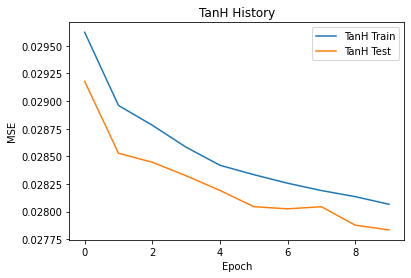

In [44]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='TanH Train')
plt.plot(history.history['val_mse'], label = 'TanH Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("TanH History")
print(f"(TanH):\tMSE={test_acc}")

Looking at the graph shows a very similar history to when ReLu is used with no significant differences.

#### ReLu & TanH

Alternating between using ReLu and TanH will also give us this below model.

In [45]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='tanh'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='tanh'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 48)                816       
                                                                 
 dense_61 (Dense)            (None, 76)                3724      
                                                                 
 dense_62 (Dense)            (None, 108)               8316      
                                                                 
 dense_63 (Dense)            (None, 76)                8284      
                                                                 
 dense_64 (Dense)            (None, 48)                3696      
                                                                 
 dense_65 (Dense)            (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

Again, no noticable improvements are observable from this change in terms of final loss.

(ReLu + TanH):	MSE=0.02792140655219555


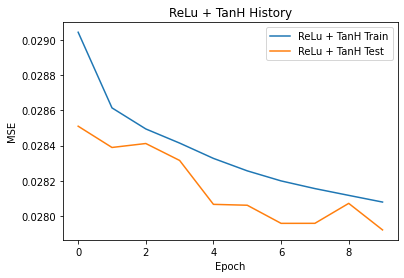

In [46]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='ReLu + TanH Train')
plt.plot(history.history['val_mse'], label = 'ReLu + TanH Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("ReLu + TanH History")
print(f"(ReLu + TanH):\tMSE={test_acc}")

However, looking at the graph shows that the testing error has a higher variance when using both activations.

Due to a lack of significant differences between which activation function is used, our final model will use ReLu.

### Dropout Layers

The only reasonable place to add a dropout layer in our working model is right before the output layer.

In [49]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 48)                816       
                                                                 
 dense_73 (Dense)            (None, 76)                3724      
                                                                 
 dense_74 (Dense)            (None, 108)               8316      
                                                                 
 dense_75 (Dense)            (None, 76)                8284      
                                                                 
 dense_76 (Dense)            (None, 48)                3696      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_77 (Dense)            (None, 1)               

Adding the dropout layer doesn't appear to have a noticable effect on our model.

(Dropout):	MSE=0.027886485680937767


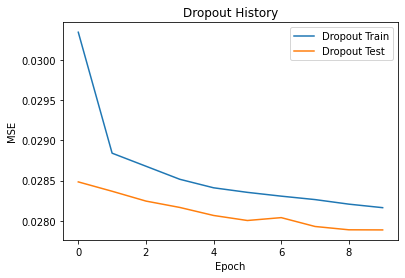

In [51]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Dropout Train')
plt.plot(history.history['val_mse'], label = 'Dropout Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Dropout History")
print(f"(Dropout):\tMSE={test_acc}")

Looking at the graph also gives off this impression, with the only significant and consistent difference being the increase in the initial training error.

Because of the increase in initial training error and a lack of other differences, our final model will not include a dropout layer.

### Optimizer

We will be comparing the performance of Adam, RMSprop, and SGD using our current model with equivalent learning rates to isolate the effect of the optimizer itself on the results.

#### Adam

First, we'll test using Adam with a learning rate of 0.001.

In [61]:
# Define the Adam optimizer.
optimizer2 = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 48)                816       
                                                                 
 dense_97 (Dense)            (None, 76)                3724      
                                                                 
 dense_98 (Dense)            (None, 108)               8316      
                                                                 
 dense_99 (Dense)            (None, 76)                8284      
                                                                 
 dense_100 (Dense)           (None, 48)                3696      
                                                                 
 dense_101 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

Using Adam consistently gives the lowest testing loss of the 3 optimizers.

(Adam):	MSE=0.027738235890865326


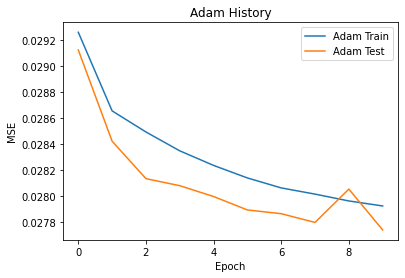

In [62]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Adam Train')
plt.plot(history.history['val_mse'], label = 'Adam Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Adam History")
print(f"(Adam):\tMSE={test_acc}")

Looking at the graph, we see that it typically is very stable in its learning as well.

#### RMSprop

Next, we'll test using RMSprop with a learning rate of 0.001 as well.

In [63]:
# Define the RMSprop optimizer.
optimizer2 = keras.optimizers.RMSprop(learning_rate=0.001, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 48)                816       
                                                                 
 dense_103 (Dense)           (None, 76)                3724      
                                                                 
 dense_104 (Dense)           (None, 108)               8316      
                                                                 
 dense_105 (Dense)           (None, 76)                8284      
                                                                 
 dense_106 (Dense)           (None, 48)                3696      
                                                                 
 dense_107 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

Although the training error progresses similarly to that of Adam, the testing loss is highly varied.

(RMSprop):	MSE=0.028381627053022385


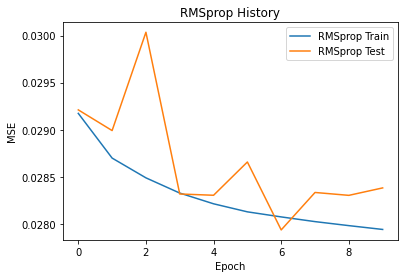

In [64]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='RMSprop Train')
plt.plot(history.history['val_mse'], label = 'RMSprop Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("RMSprop History")
print(f"(RMSprop):\tMSE={test_acc}")

This instability is very much visible in the graph, instantly eliminating this optimizer from becoming our final choice.

#### SGD

Lastly, we'll look at how our model performs when using SGD and a learning rate of 0.01.

In [67]:
# Define the SGD optimizer.
optimizer2 = keras.optimizers.SGD(learning_rate=0.01, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 48)                816       
                                                                 
 dense_115 (Dense)           (None, 76)                3724      
                                                                 
 dense_116 (Dense)           (None, 108)               8316      
                                                                 
 dense_117 (Dense)           (None, 76)                8284      
                                                                 
 dense_118 (Dense)           (None, 48)                3696      
                                                                 
 dense_119 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

From the learning data, we see that SGD improves slowly even on higher learning rates.

(SGD):	MSE=0.02937103621661663


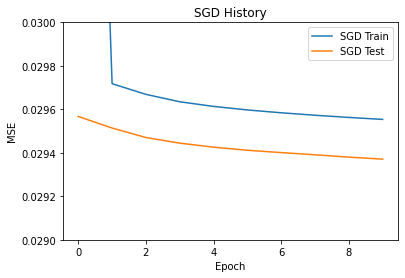

In [71]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='SGD Train')
plt.plot(history.history['val_mse'], label = 'SGD Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0.029, 0.03])
plt.legend(loc='upper right')
plt.title("SGD History")
print(f"(SGD):\tMSE={test_acc}")

From the graph, we can see that SGD is stable, however it is too slow at improving.

Although SGD wouldn't be the worst choice for our optimizer, since Adam is consistently better and quicker at converging, we will be using it for our final model.

### Learning Rates

To test the relative best learning rate for our choice of optimizer, we will examine the effects on training when shifting the decimal point.

#### Small (0.0001)

First, we will see how smaller rates than our control rate effect the convergence by using 0.0001 for the rate.

In [72]:
# Define the optimizer and learning rate.
rate = 0.0001
optimizer2 = keras.optimizers.Adam(learning_rate=rate, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 48)                816       
                                                                 
 dense_121 (Dense)           (None, 76)                3724      
                                                                 
 dense_122 (Dense)           (None, 108)               8316      
                                                                 
 dense_123 (Dense)           (None, 76)                8284      
                                                                 
 dense_124 (Dense)           (None, 48)                3696      
                                                                 
 dense_125 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

We see from our results that it converges slower than our control rate as expected, but that it is equally as stable. 

(0.0001 LR):	MSE=0.028230398893356323


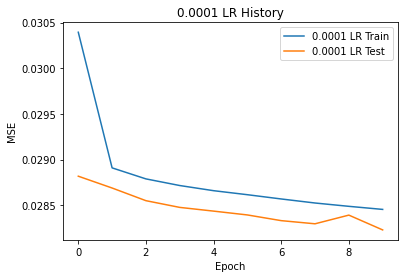

In [73]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{rate} LR Train')
plt.plot(history.history['val_mse'], label = f'{rate} LR Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{rate} LR History")
print(f"({rate} LR):\tMSE={test_acc}")

The graph equally reflects this conclusion as well. Depending on if and how we are bounded when using higher numbers of epochs, we may need to use this rate to get our best result.

#### Medium (0.001)

Our control rate will be represented by 0.001, as it has been used in all the models for the previous sections that use Adam.

In [74]:
# Define the optimizer and learning rate.
rate = 0.001
optimizer2 = keras.optimizers.Adam(learning_rate=rate, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 48)                816       
                                                                 
 dense_127 (Dense)           (None, 76)                3724      
                                                                 
 dense_128 (Dense)           (None, 108)               8316      
                                                                 
 dense_129 (Dense)           (None, 76)                8284      
                                                                 
 dense_130 (Dense)           (None, 48)                3696      
                                                                 
 dense_131 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

As expected, using this rate for 10 epochs results in a loss of around 0.0279.

(0.001 LR):	MSE=0.02783798985183239


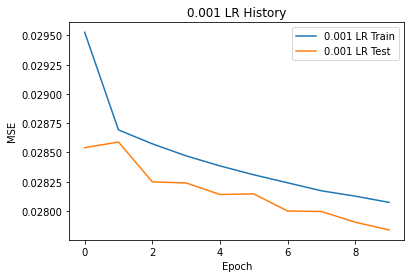

In [75]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{rate} LR Train')
plt.plot(history.history['val_mse'], label = f'{rate} LR Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{rate} LR History")
print(f"({rate} LR):\tMSE={test_acc}")

As other graphs have also shown, the testing error is relatively stable as well. This will be our final rate if higher rates do not perform as good or better than this value.

#### Large (0.01)

For testing the effect of larger rates, we will observe the effect of using 0.01 as the learning rate.

In [76]:
# Define the optimizer and learning rate.
rate = 0.01
optimizer2 = keras.optimizers.Adam(learning_rate=rate, clipnorm=1)

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer2, metric, verbose=1)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 48)                816       
                                                                 
 dense_133 (Dense)           (None, 76)                3724      
                                                                 
 dense_134 (Dense)           (None, 108)               8316      
                                                                 
 dense_135 (Dense)           (None, 76)                8284      
                                                                 
 dense_136 (Dense)           (None, 48)                3696      
                                                                 
 dense_137 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

Interestingly, we don't perform as well as our control rate, meaning we likely are quickly approaching a minimum with our control rate.

(0.01 LR):	MSE=0.02805124968290329


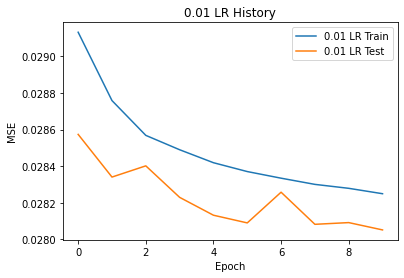

In [77]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{rate} LR Train')
plt.plot(history.history['val_mse'], label = f'{rate} LR Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{rate} LR History")
print(f"({rate} LR):\tMSE={test_acc}")

This is reflected by how the testing error is beginning to show a slope of 0 in the graph.

Because of our results with larger rates, we have chosen to stick with our control rate for the final model and switch to a smaller rate if we get stuck at a minimum with our control.

### Batch Sizes

We will now look and see how different batch sizes effect both our speed of convergence and our final error.

#### Small (128)


We will examine the effect of smaller batch sizes by observing what happens when we use 128 for our batch size.

In [78]:
# Define the number of batches.
batches = 128

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batches, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 48)                816       
                                                                 
 dense_139 (Dense)           (None, 76)                3724      
                                                                 
 dense_140 (Dense)           (None, 108)               8316      
                                                                 
 dense_141 (Dense)           (None, 76)                8284      
                                                                 
 dense_142 (Dense)           (None, 48)                3696      
                                                                 
 dense_143 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

We find that each epoch takes approximately 4 times longer to execute, but we beat our previous loss of 0.0279 with an average of 0.0278 for our testing set much earlier during training.

(128 Batches):	MSE=0.027780931442975998


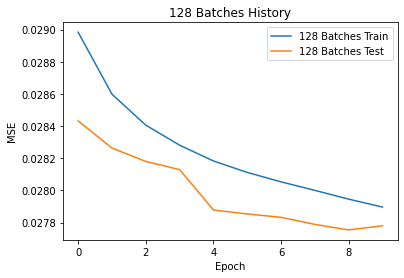

In [79]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{batches} Batches Train')
plt.plot(history.history['val_mse'], label = f'{batches} Batches Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{batches} Batches History")
print(f"({batches} Batches):\tMSE={test_acc}")

From the graph, we also see that the training curve is much smoother than higher batch rates.

#### Medium (512)

For our control, we will be using a batch size of 512 since that has been our value for previous sections.

In [88]:
# Define the number of batches.
batches = 512

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batches, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 48)                816       
                                                                 
 dense_169 (Dense)           (None, 76)                3724      
                                                                 
 dense_170 (Dense)           (None, 108)               8316      
                                                                 
 dense_171 (Dense)           (None, 76)                8284      
                                                                 
 dense_172 (Dense)           (None, 48)                3696      
                                                                 
 dense_173 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

As we've observed earlier, our error after 10 epochs is roughly 0.0279 with minor fluctuations.

(512 Batches):	MSE=0.027894288301467896


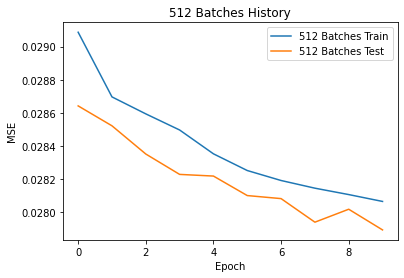

In [89]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{batches} Batches Train')
plt.plot(history.history['val_mse'], label = f'{batches} Batches Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{batches} Batches History")
print(f"({batches} Batches):\tMSE={test_acc}")

This is reflected in the graph, where we also notice that the curves are expectedly more sharp than with smaller batch sizes.

#### Large (1024)

Finally, we will investigate the effect of larger batch sizes by trying a size of 1024.

In [82]:
# Define the number of batches.
batches = 1024

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batches, epochs, model, optimizer, metric, verbose=1)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 48)                816       
                                                                 
 dense_151 (Dense)           (None, 76)                3724      
                                                                 
 dense_152 (Dense)           (None, 108)               8316      
                                                                 
 dense_153 (Dense)           (None, 76)                8284      
                                                                 
 dense_154 (Dense)           (None, 48)                3696      
                                                                 
 dense_155 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

From our results, we can see that each epoch is about twice as quick as our control, but our final error is slightly higher.

(1024 Batches):	MSE=0.02805105783045292


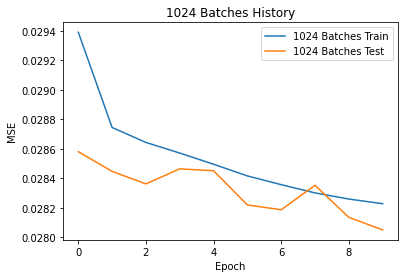

In [83]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'{batches} Batches Train')
plt.plot(history.history['val_mse'], label = f'{batches} Batches Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"{batches} Batches History")
print(f"({batches} Batches):\tMSE={test_acc}")

In the graph, the higher error causes the test accuracy to vary significantly more. Predictably, our training curve is also more jagged in comparison.

In order to obtain the best results we can with our final model in the least number of epochs, we will be using a batch size of 128.

### Loss Metric

We would also like to investigate the effect of using mean absolute error instead of mean squared error on our predictions.

#### Mean Squared Error

We'll first look at our predictions for our control model using MSE.

In [102]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, 'mse', verbose=1)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 48)                816       
                                                                 
 dense_199 (Dense)           (None, 76)                3724      
                                                                 
 dense_200 (Dense)           (None, 108)               8316      
                                                                 
 dense_201 (Dense)           (None, 76)                8284      
                                                                 
 dense_202 (Dense)           (None, 48)                3696      
                                                                 
 dense_203 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

After training, we can predict the first 50 ratings from the test set and compare them with their actual values.

In [103]:
predictions = np.reshape(model.predict(test_data_x[:50], verbose=0), -1)
# show the inputs and predicted outputs
for i in range(len(test_data_x[:50])):
	print("Expected=%.3f, Predicted=%.3f" % (test_data_y[i], predictions[i]))

Expected=1.000, Predicted=0.760
Expected=0.875, Predicted=0.878
Expected=0.925, Predicted=0.890
Expected=1.000, Predicted=0.759
Expected=0.675, Predicted=0.902
Expected=0.600, Predicted=0.807
Expected=0.600, Predicted=0.818
Expected=0.375, Predicted=0.778
Expected=0.825, Predicted=0.703
Expected=0.850, Predicted=0.716
Expected=0.775, Predicted=0.755
Expected=1.000, Predicted=0.940
Expected=0.950, Predicted=0.791
Expected=0.575, Predicted=0.782
Expected=0.725, Predicted=0.788
Expected=0.575, Predicted=0.882
Expected=0.900, Predicted=0.819
Expected=0.825, Predicted=0.814
Expected=0.750, Predicted=0.861
Expected=1.000, Predicted=0.783
Expected=0.750, Predicted=0.848
Expected=0.850, Predicted=0.691
Expected=1.000, Predicted=0.759
Expected=0.825, Predicted=0.771
Expected=0.125, Predicted=0.802
Expected=0.675, Predicted=0.734
Expected=0.625, Predicted=0.763
Expected=0.950, Predicted=0.729
Expected=0.950, Predicted=0.870
Expected=0.875, Predicted=0.739
Expected=0.350, Predicted=0.861
Expected

We see from our predictions that our model is predicting within a given range around the mean rating in the training set. This makes it more difficult for the model to predict ratings below 0.5, or 2.5 stars.

#### Mean Absolute Error

To use MAE in with our control model, we simply change the metric passed to our training function.

In [104]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(16,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, 'mae', verbose=1)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 48)                816       
                                                                 
 dense_205 (Dense)           (None, 76)                3724      
                                                                 
 dense_206 (Dense)           (None, 108)               8316      
                                                                 
 dense_207 (Dense)           (None, 76)                8284      
                                                                 
 dense_208 (Dense)           (None, 48)                3696      
                                                                 
 dense_209 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-tra

We can't compare our training progress with MSE since they are different metrics, so we'll instead compare their predictions for the test set.

In [105]:
predictions = np.reshape(model.predict(test_data_x[:50], verbose=0), -1)
# show the inputs and predicted outputs
for i in range(len(test_data_x[:50])):
	print("Expected=%.3f, Predicted=%.3f" % (test_data_y[i], predictions[i]))

Expected=1.000, Predicted=0.850
Expected=0.875, Predicted=0.869
Expected=0.925, Predicted=0.901
Expected=1.000, Predicted=0.906
Expected=0.675, Predicted=0.869
Expected=0.600, Predicted=0.926
Expected=0.600, Predicted=0.854
Expected=0.375, Predicted=0.834
Expected=0.825, Predicted=0.847
Expected=0.850, Predicted=0.765
Expected=0.775, Predicted=0.785
Expected=1.000, Predicted=0.961
Expected=0.950, Predicted=0.844
Expected=0.575, Predicted=0.843
Expected=0.725, Predicted=0.806
Expected=0.575, Predicted=0.929
Expected=0.900, Predicted=0.922
Expected=0.825, Predicted=0.855
Expected=0.750, Predicted=0.888
Expected=1.000, Predicted=0.841
Expected=0.750, Predicted=0.918
Expected=0.850, Predicted=0.751
Expected=1.000, Predicted=0.804
Expected=0.825, Predicted=0.823
Expected=0.125, Predicted=0.859
Expected=0.675, Predicted=0.781
Expected=0.625, Predicted=0.778
Expected=0.950, Predicted=0.845
Expected=0.950, Predicted=0.896
Expected=0.875, Predicted=0.820
Expected=0.350, Predicted=0.926
Expected

We see from these predictions that MAE greatly struggles with predicting lower ratings, and has a lower bias than MSE seems to possess.

Because we prefer bias over variance for this problem given the dataset we've chosen, we will be using MSE for our final model.

### Removing Features

Since our final model is significantly defined at this point, any meaningful improvements to accuracy will likely come from removing bad features. 

#### App Name

The first feature we will try removing is the app name length.

In [107]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'App Name'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

After removing it from our dataset, we need to adjust the model to expect less features.

In [108]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 48)                768       
                                                                 
 dense_211 (Dense)           (None, 76)                3724      
                                                                 
 dense_212 (Dense)           (None, 108)               8316      
                                                                 
 dense_213 (Dense)           (None, 76)                8284      
                                                                 
 dense_214 (Dense)           (None, 48)                3696      
                                                                 
 dense_215 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

From our training, we see that removing this feature failed to significantly affect the error.

(No App Name):	MSE=0.02786901779472828


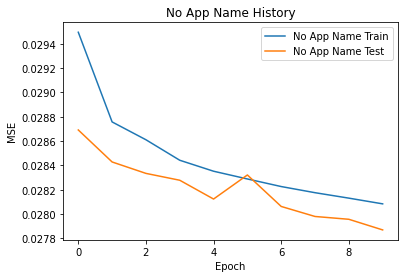

In [109]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

The graph reflects this as well, appearing quite similar to before.

Because there was no noticeable effect, removing this feature will likely not improve or worsen our final model.

#### Category

Now we'll try removing the category feature.

In [110]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Category'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

We will again need to use our adjusted model from before.

In [111]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 48)                768       
                                                                 
 dense_217 (Dense)           (None, 76)                3724      
                                                                 
 dense_218 (Dense)           (None, 108)               8316      
                                                                 
 dense_219 (Dense)           (None, 76)                8284      
                                                                 
 dense_220 (Dense)           (None, 48)                3696      
                                                                 
 dense_221 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

From our training, we see that removing the category caused a significant increase in error.

(No Category):	MSE=0.028492894023656845


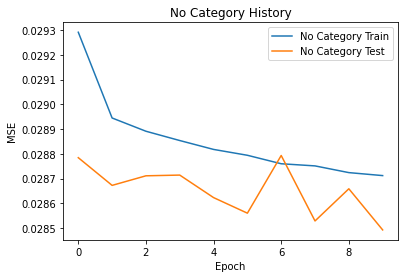

In [112]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

The large fluctuations in our test error and the sharpness of our training error come from this increase in our error.

Removing the category as a feature had a significant negative impact on the model, so it will remain in our final dataset.

#### Rating Count

Next, we'll try leaving out the rating count.

In [113]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Rating Count'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [114]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 48)                768       
                                                                 
 dense_223 (Dense)           (None, 76)                3724      
                                                                 
 dense_224 (Dense)           (None, 108)               8316      
                                                                 
 dense_225 (Dense)           (None, 76)                8284      
                                                                 
 dense_226 (Dense)           (None, 48)                3696      
                                                                 
 dense_227 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

From our training, we see no significant differences in the training error or test error from when we use all features.

(No Rating Count):	MSE=0.02791919931769371


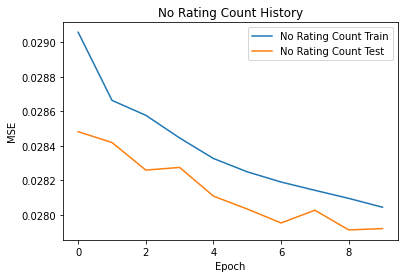

In [115]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

The graph also reflects this observation as well.

Because there was no noticeable effect, removing this feature will likely not improve or worsen our final model.

#### Maximum Installs

For this and the remaining features, we will only be addressing the graph visualization when removing the features.

In [116]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Maximum Installs'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [117]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 48)                768       
                                                                 
 dense_229 (Dense)           (None, 76)                3724      
                                                                 
 dense_230 (Dense)           (None, 108)               8316      
                                                                 
 dense_231 (Dense)           (None, 76)                8284      
                                                                 
 dense_232 (Dense)           (None, 48)                3696      
                                                                 
 dense_233 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Maximum Installs):	MSE=0.027816757559776306


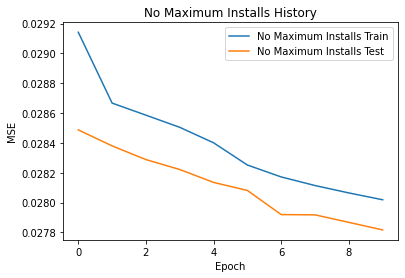

In [118]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

We see from graphing our error history that the maximum installs has a minimal impact on the predictions.

Because there was no noticeable effect, removing this feature will likely not improve or worsen our final model.

#### Free

In [119]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Free'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [120]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 48)                768       
                                                                 
 dense_235 (Dense)           (None, 76)                3724      
                                                                 
 dense_236 (Dense)           (None, 108)               8316      
                                                                 
 dense_237 (Dense)           (None, 76)                8284      
                                                                 
 dense_238 (Dense)           (None, 48)                3696      
                                                                 
 dense_239 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Free):	MSE=0.02796083129942417


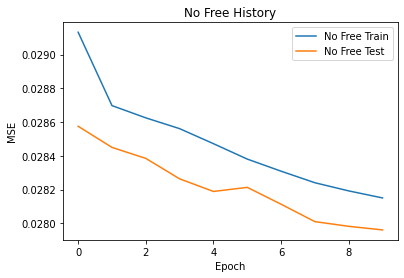

In [121]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing the free feature causes a slight increase in the model's error.

Because there was an increase in the error, removing this feature would slightly worsen our final model.

#### Price

In [122]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Price'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [123]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 48)                768       
                                                                 
 dense_241 (Dense)           (None, 76)                3724      
                                                                 
 dense_242 (Dense)           (None, 108)               8316      
                                                                 
 dense_243 (Dense)           (None, 76)                8284      
                                                                 
 dense_244 (Dense)           (None, 48)                3696      
                                                                 
 dense_245 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Price):	MSE=0.02802916057407856


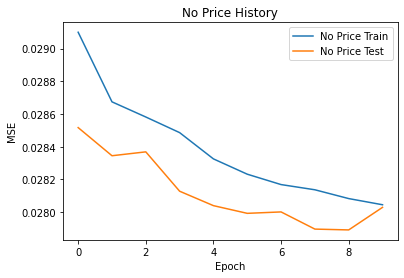

In [124]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing the price feature has no noticeable effect on the model.

Because of this, removing or retaining this feature would not significantly affect results.

#### Currency

In [125]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Currency'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [126]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 48)                768       
                                                                 
 dense_247 (Dense)           (None, 76)                3724      
                                                                 
 dense_248 (Dense)           (None, 108)               8316      
                                                                 
 dense_249 (Dense)           (None, 76)                8284      
                                                                 
 dense_250 (Dense)           (None, 48)                3696      
                                                                 
 dense_251 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Currency):	MSE=0.027830924838781357


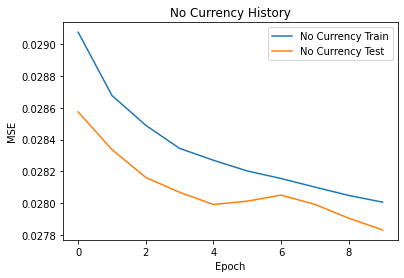

In [127]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing the currency feature appears to have no effect on the error.

This means that whether or not it remains in the dataset is inconsequential to our final results.

#### Minimum Android

In [128]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Minimum Android'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [129]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 48)                768       
                                                                 
 dense_253 (Dense)           (None, 76)                3724      
                                                                 
 dense_254 (Dense)           (None, 108)               8316      
                                                                 
 dense_255 (Dense)           (None, 76)                8284      
                                                                 
 dense_256 (Dense)           (None, 48)                3696      
                                                                 
 dense_257 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Minimum Android):	MSE=0.02790869027376175


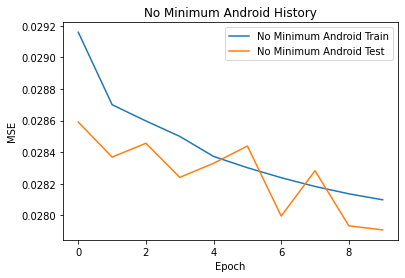

In [130]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing this feature appears to cause our test error to fluctuate occasionally during training sessions.

Because its removal negatively affects our model's stability, this feature will remain in our final dataset.

#### Developer Id

In [131]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Developer Id'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [132]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_258 (Dense)           (None, 48)                768       
                                                                 
 dense_259 (Dense)           (None, 76)                3724      
                                                                 
 dense_260 (Dense)           (None, 108)               8316      
                                                                 
 dense_261 (Dense)           (None, 76)                8284      
                                                                 
 dense_262 (Dense)           (None, 48)                3696      
                                                                 
 dense_263 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Developer Id):	MSE=0.02805451676249504


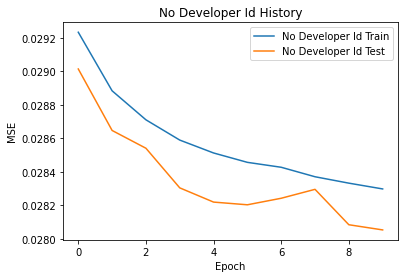

In [133]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing this feature caused our error to increase slightly in both sets.

Since its removal increased the error, the feature will remain in the final dataset.

#### Released

In [134]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Released'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [135]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 48)                768       
                                                                 
 dense_265 (Dense)           (None, 76)                3724      
                                                                 
 dense_266 (Dense)           (None, 108)               8316      
                                                                 
 dense_267 (Dense)           (None, 76)                8284      
                                                                 
 dense_268 (Dense)           (None, 48)                3696      
                                                                 
 dense_269 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Released):	MSE=0.028314201161265373


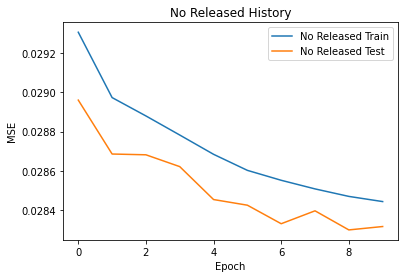

In [136]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Our error experienced a noticeable increase upon removing this feature.

Because of this, it will remain in our final dataset.

#### Last Updated

In [137]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Last Updated'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [138]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, 48)                768       
                                                                 
 dense_271 (Dense)           (None, 76)                3724      
                                                                 
 dense_272 (Dense)           (None, 108)               8316      
                                                                 
 dense_273 (Dense)           (None, 76)                8284      
                                                                 
 dense_274 (Dense)           (None, 48)                3696      
                                                                 
 dense_275 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Last Updated):	MSE=0.02810455858707428


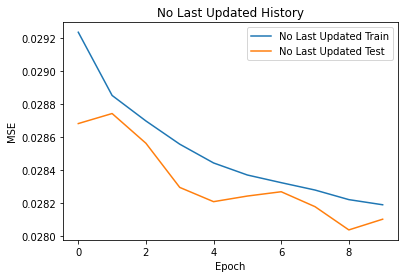

In [139]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Because the released feature is significantly linked to this one, this feature's removal also causes an increase in the model's error.

This means that this feature will also be left in the final dataset for the same reasons.

#### Content Rating

In [140]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Content Rating'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [141]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 48)                768       
                                                                 
 dense_277 (Dense)           (None, 76)                3724      
                                                                 
 dense_278 (Dense)           (None, 108)               8316      
                                                                 
 dense_279 (Dense)           (None, 76)                8284      
                                                                 
 dense_280 (Dense)           (None, 48)                3696      
                                                                 
 dense_281 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Content Rating):	MSE=0.027886327356100082


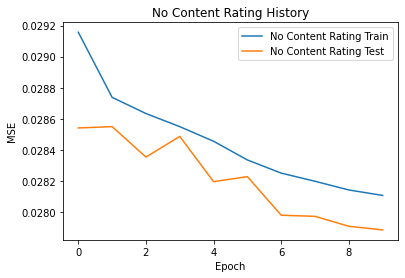

In [142]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing the content rating appears to have no notable effect on the error.

Thus, this feature's presence will have very little impact on our results.

#### Ad Supported

In [143]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Ad Supported'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [144]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_282 (Dense)           (None, 48)                768       
                                                                 
 dense_283 (Dense)           (None, 76)                3724      
                                                                 
 dense_284 (Dense)           (None, 108)               8316      
                                                                 
 dense_285 (Dense)           (None, 76)                8284      
                                                                 
 dense_286 (Dense)           (None, 48)                3696      
                                                                 
 dense_287 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Ad Supported):	MSE=0.028005456551909447


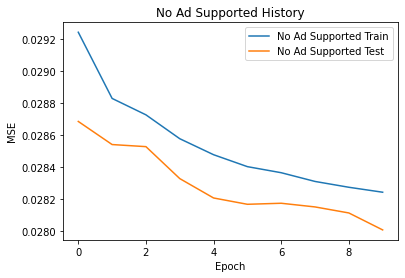

In [145]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing this feature had a slight, but perhaps negligible, increase in our error.

Because of this, it will be left in the final dataset.

#### In App Purchases

In [146]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'In App Purchases'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [147]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 48)                768       
                                                                 
 dense_289 (Dense)           (None, 76)                3724      
                                                                 
 dense_290 (Dense)           (None, 108)               8316      
                                                                 
 dense_291 (Dense)           (None, 76)                8284      
                                                                 
 dense_292 (Dense)           (None, 48)                3696      
                                                                 
 dense_293 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No In App Purchases):	MSE=0.027872340753674507


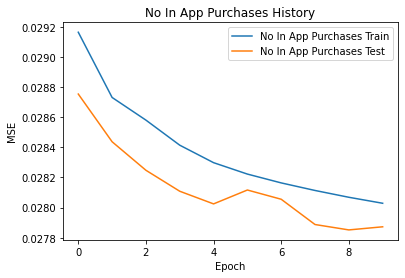

In [148]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing this feature had no significant impact on the error.

Thus, its presence in our final dataset is insignificant.

#### Editor's Choice

In [149]:
# Remove the appropriate columns from our train and test sets.
removedFeature = 'Editors Choice'
xTrain, xTest = train_data.drop(columns=['Rating', removedFeature]), test_data.drop(columns=['Rating', removedFeature])
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

In [150]:
# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(15,)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_294 (Dense)           (None, 48)                768       
                                                                 
 dense_295 (Dense)           (None, 76)                3724      
                                                                 
 dense_296 (Dense)           (None, 108)               8316      
                                                                 
 dense_297 (Dense)           (None, 76)                8284      
                                                                 
 dense_298 (Dense)           (None, 48)                3696      
                                                                 
 dense_299 (Dense)           (None, 1)                 49        
                                                                 
Total params: 24,837
Trainable params: 24,837
Non-tra

(No Editors Choice):	MSE=0.02781132236123085


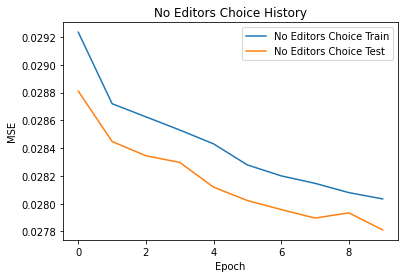

In [151]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label=f'No {removedFeature} Train')
plt.plot(history.history['val_mse'], label = f'No {removedFeature} Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title(f"No {removedFeature} History")
print(f"(No {removedFeature}):\tMSE={test_acc}")

Removing the editors choice feature expectedly had no effect on the error.

Since it's insignificant if it remains, this feature will be left in the final dataset solely for making comparisons.

Different combinations of removed features would likely have a significant impact on the results and perhaps lower the error further, but time constraints for this project prevent us from testing all possible combinations. 

Because of this and the results we know from above, our final model will include all 16 of the initial features.

## Final Model & Results

Using our findings from the previous sections, we construct what should be close to the optimal model for our dataset.

In [14]:
# Remove the appropriate columns from our train and test sets.
removedFeatures = ['Rating']
xTrain, xTest = train_data.drop(columns=removedFeatures), test_data.drop(columns=removedFeatures)
xTrain = np.reshape(xTrain.values, (xTrain.shape[0], -1))
xTest = np.reshape(xTest.values, (xTest.shape[0], -1))

# Training settings.
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
batch_size = 128
metric = 'mse'
epochs = 25

# Create and train the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(xTrain.shape[1],)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()
history, test_loss, test_acc = Train_Model(batch_size, epochs, model, optimizer, metric, train_x=xTrain, test_x=xTest, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                816       
                                                                 
 dense_1 (Dense)             (None, 76)                3724      
                                                                 
 dense_2 (Dense)             (None, 108)               8316      
                                                                 
 dense_3 (Dense)             (None, 76)                8284      
                                                                 
 dense_4 (Dense)             (None, 48)                3696      
                                                                 
 dense_5 (Dense)             (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-traina

In [19]:
# Save our best model's weights to Google Drive for later reference.
model.save_weights("/content/drive/MyDrive/PlayStore/final_weights.hdf5")

When training for 25 epochs, we reach a minimal MSE of 0.0275 with our model. If given longer, it could potentially decrease further, but not by much.

For the final time, we then graph our loss history for both the training and testing set.

(Final Model):	MSE=0.027523083612322807


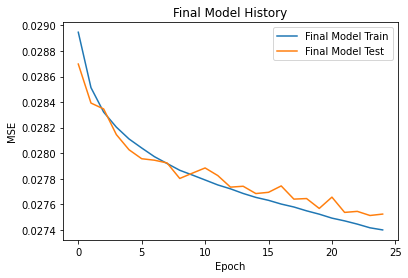

In [15]:
# Make visuals for evaluating.
plt.plot(history.history['mse'], label='Final Model Train')
plt.plot(history.history['val_mse'], label = 'Final Model Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title("Final Model History")
print(f"(Final Model):\tMSE={test_acc}")

From our graph, we see that the decrease in our training and testing error is extremely small past the 10th epoch and that it has essentially flattened out.

Using this trained model, we will examine the first 50 predictions it makes in our test set.

In [16]:
predictions = np.reshape(model.predict(test_data_x[:50], verbose=0), -1)
# show the inputs and predicted outputs
for i in range(len(test_data_x[:50])):
	print("Expected=%.3f, Predicted=%.3f" % (test_data_y[i], predictions[i]))

Expected=1.000, Predicted=0.771
Expected=0.250, Predicted=0.892
Expected=0.675, Predicted=0.829
Expected=0.800, Predicted=0.878
Expected=0.600, Predicted=0.833
Expected=0.850, Predicted=0.794
Expected=0.800, Predicted=0.728
Expected=0.900, Predicted=0.802
Expected=0.775, Predicted=0.647
Expected=0.375, Predicted=0.708
Expected=0.325, Predicted=0.697
Expected=0.675, Predicted=0.836
Expected=0.975, Predicted=0.848
Expected=1.000, Predicted=0.795
Expected=0.825, Predicted=0.700
Expected=0.850, Predicted=0.728
Expected=0.525, Predicted=0.859
Expected=0.700, Predicted=0.674
Expected=0.925, Predicted=0.794
Expected=0.925, Predicted=0.808
Expected=0.675, Predicted=0.756
Expected=0.975, Predicted=0.776
Expected=0.950, Predicted=0.775
Expected=0.425, Predicted=0.751
Expected=0.750, Predicted=0.792
Expected=0.350, Predicted=0.700
Expected=0.400, Predicted=0.850
Expected=0.900, Predicted=0.763
Expected=0.750, Predicted=0.790
Expected=0.950, Predicted=0.864
Expected=0.125, Predicted=0.799
Expected

Due to the size of our error, the inaccuracies in these predictions are to be expected. Notably, they continue to struggle with deviating from the mean rating.

Finally we graph the feature importance for these first 50 predictions.

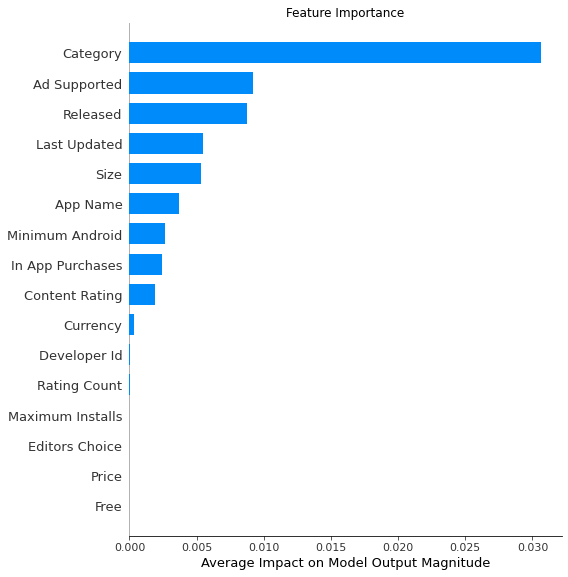

In [18]:
# Initialize SHAP.
shap.initjs()

# Explain the importance of features.
explainer = shap.DeepExplainer(model, test_data_x[:50])
shap_values = explainer.shap_values(test_data_x[:50])

# Visualize the first prediction's explanation using matplotlib.
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0][:], test_data_x[0][:], show=False)
shap.summary_plot(shap_values, test_data_x, plot_type="bar", feature_names=list(test_data.drop(columns=['Rating']).columns), show=False)
plt.title("Feature Importance") 
plt.xlabel("Average Impact on Model Output Magnitude")
plt.legend('',frameon=False)
plt.show()

It's noteworthy that the above chart will vary from one training session to another, but the general conclusions are normally the same. 

Category and Ad-Supported are typically the two most important features, followed by Last Updated or Released, which is then followed by In App Purchases, App Name, or Size. Minimum Android, Currency, and Content Rating then follow in varying order. The Price, Developer Id, Rating Count, Maximum Installs, Free, and Editor's Choice all have statistically 0no importance on the predictions.

## Data Subset Evaluation

The purpose of this section is so that future evaluators may load our best model and evaluate it using the first 50 samples of our test set.

Before executing the following code blocks, ensure that you have first ran the blocks within the [Modules](#modules) section and placed the necessary files in your Google Drive as in the locations specified by the README file.

First we load the tokenized and truncated test dataset.

In [5]:
# Load the tokenized test dataset.
test_data = pd.read_csv("/content/drive/MyDrive/PlayStore/Test-Data.csv", delimiter=',', index_col=0)

# Split the data into the x and y sets.
test_data_x = test_data.drop(columns=['Rating'])
test_data_y = test_data['Rating']

# Reshape them as numpy arrays.
test_data_x = np.reshape(test_data_x.values, (test_data_x.shape[0], -1))
test_data_y = np.reshape(test_data_y.values, -1)

Then we recreate the model and load the trained weights from drive.

In [6]:
# Recreate the model.
model = keras.models.Sequential()
model.add(keras.layers.Dense(48, activation='relu', input_shape=(test_data_x.shape[1],)))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(108, activation='relu'))
model.add(keras.layers.Dense(76, activation='relu'))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Load the trained weights.
model.load_weights("/content/drive/MyDrive/PlayStore/final_weights.hdf5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 48)                816       
                                                                 
 dense_7 (Dense)             (None, 76)                3724      
                                                                 
 dense_8 (Dense)             (None, 108)               8316      
                                                                 
 dense_9 (Dense)             (None, 76)                8284      
                                                                 
 dense_10 (Dense)            (None, 48)                3696      
                                                                 
 dense_11 (Dense)            (None, 1)                 49        
                                                                 
Total params: 24,885
Trainable params: 24,885
Non-trai

We then make predictions on this truncated dataset and print them as we have for our final results.

In [7]:
# Make predictions on our test data.
predictions = np.reshape(model.predict(test_data_x, verbose=0), -1)
# Show the inputs and predicted outputs
for i in range(len(test_data_x[:50])):
	print("Expected=%.3f, Predicted=%.3f" % (test_data_y[i], predictions[i]))

Expected=1.000, Predicted=0.771
Expected=0.250, Predicted=0.892
Expected=0.675, Predicted=0.829
Expected=0.800, Predicted=0.878
Expected=0.600, Predicted=0.833
Expected=0.850, Predicted=0.794
Expected=0.800, Predicted=0.728
Expected=0.900, Predicted=0.802
Expected=0.775, Predicted=0.647
Expected=0.375, Predicted=0.708
Expected=0.325, Predicted=0.697
Expected=0.675, Predicted=0.836
Expected=0.975, Predicted=0.848
Expected=1.000, Predicted=0.795
Expected=0.825, Predicted=0.700
Expected=0.850, Predicted=0.728
Expected=0.525, Predicted=0.859
Expected=0.700, Predicted=0.674
Expected=0.925, Predicted=0.794
Expected=0.925, Predicted=0.808
Expected=0.675, Predicted=0.756
Expected=0.975, Predicted=0.776
Expected=0.950, Predicted=0.775
Expected=0.425, Predicted=0.751
Expected=0.750, Predicted=0.792
Expected=0.350, Predicted=0.700
Expected=0.400, Predicted=0.850
Expected=0.900, Predicted=0.763
Expected=0.750, Predicted=0.790
Expected=0.950, Predicted=0.864
Expected=0.125, Predicted=0.799
Expected

We then use SHAP to again show the feature importance in making these predictions.

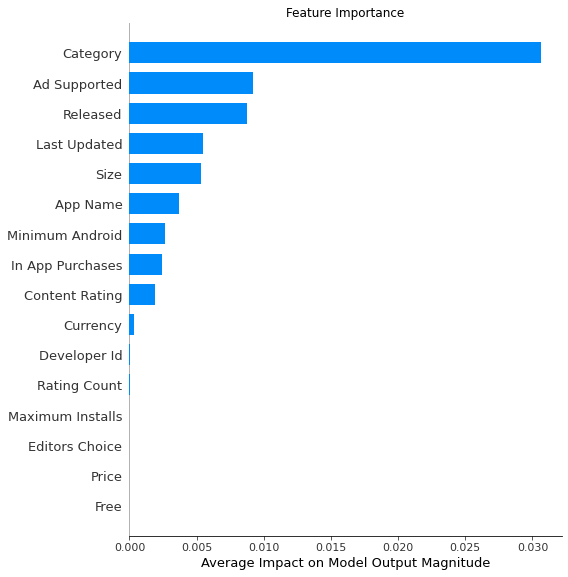

In [9]:
# Initialize SHAP.
shap.initjs()

# Explain the importance of features.
explainer = shap.DeepExplainer(model, test_data_x)
shap_values = explainer.shap_values(test_data_x)

# Visualize the first prediction's explanation using matplotlib.
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0][:], test_data_x[0][:], show=False)
shap.summary_plot(shap_values, test_data_x, plot_type="bar", feature_names=list(test_data.drop(columns=['Rating']).columns), show=False)
plt.title("Feature Importance") 
plt.xlabel("Average Impact on Model Output Magnitude")
plt.legend('',frameon=False)
plt.show()